<a href="https://colab.research.google.com/github/alberba/Aprendizaje-Autom-tico/blob/main/16_SAM/SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SAM

Segment Anything és un projecte de **Meta** amb dues grans aportacions:

- Un gran conjunt de dades per a la segmentació d'imatges
- El model Segment Anything (SAM) com a model de base per a la segmentació d'imatges

Va ser introduït a l'article **Segment Anything** per Alexander Kirillov _et al._** (Abril 2023) [enllaç](https://arxiv.org/pdf/2304.02643.pdf)

Aquest model s'inspira en el camp de la NLP (_Natural Language Processing_), on la creació de models base (**
_foundation models_**) i els grans conjunts de dades (per valor de milers de milions de dades) s'han convertit en la manera habitual de fer feina.


Com ja sabem, la segmentació d'imatges té diversos usos, aquests inclouen: l'anàlisi d'imatges biomèdiques, l'edició de fotografies i la conducció autònoma, entre d'altres. Per resoldre qualsevol d'aquests problemes, cal entrenar models especialitzats per cada una de les tasques que hem citat (és més, per cada un dels subproblemes que es deriven de cada tasca i per cada cas en particular). Això requereix un ampli coneixement del domini del problema i el temps necessari per a la recollida de dades específiques, per no parlar de les hores d'entrenament i ajustamen que són necessàries per als models d'aprenentatge profund.

Enllaços:
- [Repositòri Oficial](https://github.com/facebookresearch/segment-anything)
- [Demo for dummies](https://segment-anything.com/demo)
- [Ultralytics1](https://docs.ultralytics.com/models/sam/) i [Ultralytics2](https://docs.ultralytics.com/models/sam2/)


In [1]:
!pip install -U ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.8/898.8 kB 28.3 MB/s eta 0:00:00


## Model

SAM és un model d'aprenentatge profund (basat en _transformers_). I com amb qualsevol aprenentatge profund, s'ha entrenat en un gran nombre d'imatges i màscares: **més de mil milions de màscares en 11 milions d'imatges**.

Com SAM és una model base, i està preparat per segmentar qualsevol tipus d'imatge, pot rebre indicacions dels usuaris sobre quina àrea segmentar. Actualment podem proporcionar tres indicacions diferents a SAM:

- Indicar punts que contenen i no contenen el que volem segmentar.
- Dibuixant un quadre delimitador (_bounding box_).
- Dibuixant una màscara genearl sobre un objecte.

En l'article és parla de preparar un _promt_ per poder especificar el que es vol segmentar emprant text.

L'arquitectura de la xarxa és la següent:

![SAM](https://learnopencv.com/wp-content/uploads/2023/04/segment-anything-model.png)


Les caracterìstiques més importants del model (secció 3 de l'article) són:

**Encoder**. Vision Transformer (ViT) basat en la idea d'un MAE (Masked AutoEncoder) El codificador d'imatge s'executa una vegada per imatge i es pot aplicar abans de sol·licitar el
_prompt_ al model.

**Codificador de _prompts_**. S'en consideren dos tipus: dispersos (punts, _bounding boxes_, text) i densos (màscares). Representen els punts i les _bounding boxes_ mitjançant codificacions posicionals amb altres informacions apreses per a cada tipus d'_input_ i text de forma lliure amb un codificador de text anomenat CLIP. Les indicacions denses (és a dir, les màscares) s'incorporen mitjançant l'ús convolucions i es sumen (concatenen) amb la codificació obtinguda de l'encoder de la imatge.

**Descodificador de màscares**. El descodificador de màscara mapeja de manera eficient els _embeddings_ d'una imatge i el resultat del codificador de _prompts_ utilitzant una modificació d'un bloc descodificador Transformer

**Resolució de l'ambigüitat**. Amb una sortida, el model farà una mitjana de diverses màscares vàlides si se li dóna una indicació ambigua. Per solucionar-ho, modifiquem el model per predir múltiples màscares de sortida per a un sol _prompt_ d'entreada. Experimentalment s'ha arribat a la conclusió que 3 màscares de sortida de màscara són suficients per abordar els casos més habituals (les màscares imbricades solen tenir tres profunditats com a màxim: senceres, parcials i subparts).

**Eficiència**. El disseny global del model està motivat en gran mesura per l'eficiència. Donat un _embedding_ precalculat d'una imatge, el codificador de _promts_ i el descodificador de màscares s'executen en un navegador web, a la CPU, en ∼50 ms. Aquest rendiment en temps d'execució permet una indicació interactiva en temps real del model.

**Pèrdues i entrenament.** Es supervisa la predicció de les màscares amb la combinació lineal d'una funció de pèrdua focal [enllaç](https://paperswithcode.com/method/focal-loss) i una funció de pèrdua de dice (ja emprada al model YOLO). L'entrenament es realitza utilitzant una barreja d'indicacions geomètriques, es simula un entrenament interactiu mitjançant un mostreig aleatori de prompts en 11 rondes per màscara.


## Dades

Com ja sabem, la base de qualsevol model d'aprenentatge profund innovador és el conjunt de dades en què s'ha entrenat. El conjunt de dades de SAM conté més d'**11 milions d'imatges i 1.100 milions de màscares**. El conjunt de dades final s'anomena conjunt de dades SA-1B.

Segurament es necessita aquest conjunt de dades per entrenar un model de capacitat de Segment Anything. Però també sabem que aquests conjunts de dades no existeixen i que és impossible anotar manualment tantes imatges.Per tant es necessitar l'ajut de SAM per anotar el conjunt de dades: Els anotadors de dades van utilitzar SAM per anotar imatges de manera interactiva i les dades anotades es van utilitzar per entrenar SAM. Aquest procés es va repetir, cosa que va donar lloc al motor de dades en bucle de SAM.

Aquest motor de dades + formació del SAM al conjunt de dades té tres etapes:

- Etapa Manual Assistida
- Etapa semiautomàtica
- Etapa totalment automàtica

En la primera etapa, els anotadors van utilitzar un model SAM prèviament entrenat per segmentar objectes de manera interactiva en imatges al navegador. Els _embeddings_ de les imatges es van calcular prèviament per fer que el procés d'anotació fos fluid i en temps real. Després de la primera etapa, el conjunt de dades constava de 4,3 milions de màscares a partir  de 120.000 imatges. El model Segment Anything es va tornar a entrenar en aquest conjunt de dades.

En la segona etapa semiautomàtica, els objectes destacats ja estaven segmentats mitjançant SAM. Els anotadors també van anotar objectes menys destacats que no tenien anotació. Aquesta etapa va donar lloc a 5,9 milions de màscares addicionals en 180.000 imatges en les quals es va tornar a entrenar SAM.

A l'etapa "totalment automàtica" final, l'anotació la va fer íntegrament SAM. En aquesta etapa, ja s'havia entrenat el model en més de 10 milions de màscares que ho van fer possible. La generació automàtica de màscares es va aplicar 11M a imatges , donant lloc a 1,1B  màscares.
En paraules del seus creadors:

"La versió final del conjunt de dades Segment Anything el converteix en el conjunt de dades de segmentació d'imatges més gran disponible públicament. En comparació amb OpenImages V5, hi ha 6 vegades més imatges i 400 vegades més màscares al conjunt de dades."

## SAM2

SAM2 presenta una evolució de SAM, va ser publicat l'octubre de l'any 2024. [SAM 2: Segment Anything in Images and Videos](https://arxiv.org/pdf/2408.00714)

SAM2 pot segmentar qualsevol objecte en qualsevol vídeo o imatge, fins i tot per a objectes i dominis visuals que no hagi vist anteriorment, permetent una àmplia gamma de casos d'ús sense adaptació personalitzada.

Meta distibueix:
- El codi i els pesos SAM 2, que s'estan de codi obert sota una llicència permissiva d'Apache 2.0.
- El conjunt de dades SA-V, que té 4,5 vegades més vídeos i 53 vegades més anotacions que el conjunt de dades de segmentació de vídeo més gran existent. - Aquesta versió inclou ~ 51.000 vídeos del món real amb més de 600.000 mascares.
- Una [demo](https://sam2.metademolab.com/) que permet la segmentació interactiva en temps real de vídeos curts i aplica efectes de vídeo a les prediccions del model.



L'arquitectura de SAM2 s'ha adaptat per poder processar videos, però també s'ha treballat en reduïr la seva mida. En la [següent taula](https://docs.ultralytics.com/models/sam-2/#sam-2-comparison-vs-yolov8) en podem veure una comparativa molt interessant.

## Tutorial

Hi ha 3 models diferents preentrenats de SAM:

- ViT-B SAM
- ViT-L SAM
- ViT-H SAM

Per altra banda, tenim 4 models diferents de SAM2 (i de SAM2.1):

- sam2_hiera_tiny
- sam2_hiera_small
- sam2_hiera_base_plus
- sam2_hiera_large



Tal com passava amb YOLO es pot emprar SAM i SAM2 descarregant el model i/o els pesos desde els seus resperctius repositoris:

- SAM [enllaç](https://github.com/facebookresearch/segment-anything#model-checkpoints).

- SAM2 [enllaç](https://github.com/facebookresearch/sam2).

Aquests models estàn implementats amb Pytorch i tenir la possibilitat d'accedir al codi font ens podría servir per tasques d'investigació.

Per altra banda la empresa Ultralytics ha portat aquests dos models al seu entorn, amb la limitació que només podem fer predicció amb les condicions/restriccions de l'entron, però també aprofitant la seva simplesa.

### Feina a fer
0. Segmentar una única cel·lula a la imatge anomenada _cells.jpg_ que es troba a la carpeta _imgs_ mitjançant la selecció d'un punt i dibuixar la seva _bounding box_.
1. Contar el nombre de cel·lules a la imatge anomenada _cells.jpg_ que es troba a la carpeta _imgs_.

![celules](imgs/cells.jpg "celules")

2. Segmentar un dels tres joves que apareixen a la imatge _str.jpg_, mostrar el resultat de la segmentació posant de color negre tot el que no sigui part de la segmentació. L'exercici és més senzill si emprau una bounding box.

![str](imgs/str.jpg "str")

3. Segmentar els tres joves emprant YOLO i una de les dues versions de SAM.

A continuació teniu un exemple d'execució útil tant per SAM com per SAM2

In [3]:
from ultralytics.models.sam import Predictor as SAMPredictor
from ultralytics.models.sam import SAM2VideoPredictor ## Per fer segmentació sobre vídeos

# Diccionari amb la configuració del predictor
overrides = dict(imgsz=1024, model="mobile_sam.pt") # Si teniu moltes limitacions hard: mobile_sam.pt
predictor = SAMPredictor(overrides=overrides)
predictor.reset_image()
# Assignam una imatge al predictor
predictor.set_image("imgs/cells.jpg")  #pot ser un path o una url o un ndarray (numpy)


# Exemple 1: Segmentació indicant un punt d'interés amb coordenades (x,y)
results = predictor(points=[616, 200], labels=[0])  # label 1 indica objecte; label 0 indica fons

# Exemple 2: Segmentació indicant dos punts d'interés amb coordenades (x1,y1); (x2,y2)
#results = predictor(points=[[x1, y1], [x2, y2]], labels=[[1, 1]])

# Exemple 3
#results = predictor(points=[[[x1, y1], [x2, y2]]], labels=[[1, 0]])

# Exemple 4: Segmentació indicant caixa
#results = predictor(bboxes=[[[606,75], [886, 575]]] )

# Exemple 4: Segmentació indicant caixa
#results = predictor(bboxes=[[[xi,yi], [xi, yf]]], points=[x,y], labels=[z] )
# Reset image
#predictor.reset_image()

Ultralytics 8.3.48 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

image 1/1 /content/imgs/cells.jpg: 1024x1024 1 0, 899.6ms
Speed: 6.5ms preprocess, 899.6ms inference, 163.6ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to runs/segment/predict


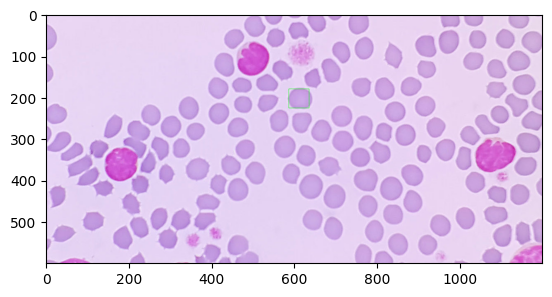

In [4]:
import cv2
import matplotlib.pyplot as plt

rectangles = results[0].boxes.xyxy.cpu().numpy()
for rectangle in rectangles:
    rectangle = rectangle.astype(int)

    imatge = cv2.imread("imgs/cells.jpg")

    img2 = cv2.rectangle(imatge, (rectangle[0], rectangle[1]), (rectangle[2], rectangle[3]), (0, 255, 0))
plt.imshow(img2)


In [8]:
# Apartado 2
# Diccionari amb la configuració del predictor
overrides = dict(imgsz=1024, model="mobile_sam.pt") # Si teniu moltes limitacions hard: mobile_sam.pt
predictor = SAMPredictor(overrides=overrides)
predictor.reset_image()
# Assignam una imatge al predictor
predictor.set_image("imgs/cells.jpg")  #pot ser un path o una url o un ndarray (numpy)
# Realizar la segmentación de todas las células
results = predictor()

# Extraer las máscaras de los resultados
masks = results[0].masks.data.cpu().numpy()

# Contar el número de células detectadas
num_cells = masks.shape[0]

print(f"Number of cells detected: {num_cells}")

Ultralytics 8.3.48 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

image 1/1 /content/imgs/cells.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 1 30, 1 31, 1 32, 1 33, 1 34, 1 35, 1 36, 1 37, 1 38, 1 39, 1 40, 1 41, 1 42, 1 43, 1 44, 1 45, 1 46, 1 47, 1 48, 1 49, 1 50, 1 51, 1 52, 1 53, 1 54, 1 55, 1 56, 1 57, 1 58, 1 59, 1 60, 1 61, 1 62, 1 63, 1 64, 1 65, 1 66, 1 67, 1 68, 1 69, 1 70, 1 71, 1 72, 1 73, 1 74, 1 75, 1 76, 1 77, 1 78, 1 79, 1 80, 1 81, 1 82, 1 83, 1 84, 1 85, 1 86, 1 87, 1 88, 1 89, 1 90, 1 91, 1 92, 1 93, 1 94, 1 95, 1 96, 1 97, 1 98, 1 99, 1 100, 1 101, 1 102, 1 103, 1 104, 1 105, 1 106, 1 107, 1 108, 1 109, 1 110, 1 111, 1 112, 1 113, 1 114, 1 115, 1 116, 1 117, 1 118, 1 119, 1 120, 1 121, 1 122, 1 123, 1 124, 1 125, 1 126, 1 127, 1 128, 1 129, 1 130, 1 131, 1 132, 1 133, 1 134, 1 135, 1 136, 1 137, 1 138, 1 139, 1 

In [9]:
results[0].masks.shape

torch.Size([153, 600, 1200])

Ultralytics 8.3.48 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

image 1/1 /content/imgs/str.jpg: 1024x1024 1 0, 15.0ms
Speed: 3.6ms preprocess, 15.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to runs/segment/predict4


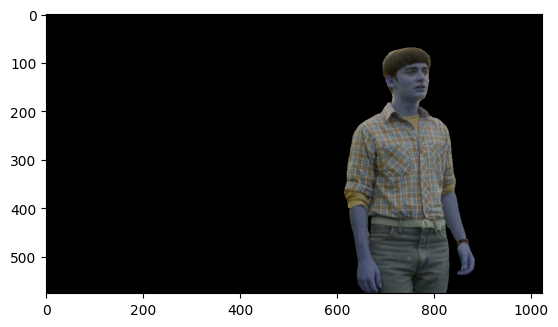

In [10]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Apartado 3
# Diccionari amb la configuració del predictor
overrides = dict(imgsz=1024, model="mobile_sam.pt") # Si teniu moltes limitacions hard: mobile_sam.pt
predictor = SAMPredictor(overrides=overrides)
predictor.reset_image()
# Assignam una imatge al predictor
predictor.set_image("imgs/str.jpg")  #pot ser un path o una url o un ndarray (numpy)
results = predictor(bboxes=[[[606,75], [886, 575]]] )

# Exemple 1: Segmentació indicant un punt d'interés amb coordenades (x,y)

# Extraer la máscara de los resultados
mask = results[0].masks[0].data.cpu().numpy()  # Convertir a numpy

# Leer la imagen original
imagen = cv2.imread("imgs/str.jpg")

imagen[~mask[0]] = 0

# Mostrar la imagen segmentada
plt.imshow(imagen)


També es pot fer una predicció de tota la imatge. No és recomanable ja que el temps d'inferéncia augmenta considerablement però pot ser d'utilitat en certs casos

In [ ]:
from ultralytics import SAM

# Carregam un model
model = SAM("mobile_sam.pt")

# Display model information (optional)
model.info()

# Executar l'inferència tal com ho feim a pytorch. Aquí podem passar la imatge directament.
model("imgs/str.jpg")

Model summary: 351 layers, 10,130,092 parameters, 10,130,092 gradients

image 1/1 c:\Albert\01. Proyectos\Aprendizaje Automtico\Aprendizaje-Autom-tico\16_SAM\imgs\str.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 1 30, 1 31, 1 32, 1 33, 1 34, 1 35, 1 36, 1 37, 1 38, 1 39, 1 40, 1 41, 1 42, 1 43, 1 44, 1 45, 1 46, 1 47, 1 48, 104236.4ms
Speed: 8.0ms preprocess, 104236.4ms inference, 112.0ms postprocess per image at shape (1, 3, 1024, 1024)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: ultralytics.engine.results.Masks object
 names: {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '10', 11: '11', 12: '12', 13: '13', 14: '14', 15: '15', 16: '16', 17: '17', 18: '18', 19: '19', 20: '20', 21: '21', 22: '22', 23: '23', 24: '24', 25: '25', 26: '26', 27: '27', 28: '28', 29: '29', 30: '30', 31: '31', 32: '32', 33: '33', 34: '34', 35: '35', 36: '36', 37: '37', 38: '38', 39: '39', 40: '40', 41: '41', 42: '42', 43: '43', 44: '44', 45: '45', 46: '46', 47: '47', 48: '48'}
 obb: None
 orig_img: array([[[215, 208, 191],
         [215, 209, 190],
         [214, 208, 189],
         ...,
         [219, 215, 197],
         [218, 214, 196],
         [217, 213, 195]],
 
        [[215, 210, 189],
         [215, 210, 189],
         [214, 209, 188],
         ...,
         [220, 216, 198],
         [219, 215, 197],
        